In [1]:
import sys

In [2]:
import simpleaudio as sa
import wave
from scipy.io import wavfile
import scipy.io
from matplotlib import pyplot as plt
import numpy as np
from scipy.fft import fft,fftfreq,ifft
from math import exp
import math
from IPython.display import Audio
from scipy.io.wavfile import read,write
import wave
import librosa
import scipy as sp

In [3]:
####importing file
filename = 'Output 1-2.wav'
# filename='do 32bit.wav'
#wave_obj = sa.WaveObject.from_wave_file(filename)
#play_obj = wave_obj.play()
#play_obj.wait_done()
#Audio(filename)
bitrate,data= wavfile.read(filename)
length = data.shape[0] / bitrate

#choose one channel if multichannel
if type(data[0])==type(np.array([])):
    data=data[:,0]

<ipython-input-3-19d97a11c87a>:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  bitrate,data= wavfile.read(filename)
<ipython-input-3-19d97a11c87a>:8: WavFileWarning: Incomplete chunk ID: b'\x00', ignoring it.
  bitrate,data= wavfile.read(filename)


In [4]:
length = data.shape[0] / bitrate
N = len(data)
print(' number of datapoints in total is:' ,N, '\n number of datapoints per second is: ',bitrate, '\n lenghth of the data in second is:', length, 's')

 number of datapoints in total is: 441000 
 number of datapoints per second is:  44100 
 lenghth of the data in second is: 10.0 s


In [5]:
#define window size, low pass target, high pass target, overlap
overlap=0.5
winsize = 2**13
high_pass_target=80
low_pass_target=600
zero_padding_multiple=2**2

In [6]:
possible_freq=bitrate/(winsize)*np.array(range(0,winsize))
for i in range( len(possible_freq)):
    if possible_freq[i]>= high_pass_target:
        high_pass_index=i+1
        high_pass_freq=possible_freq[i+1]
        break
for i in range( high_pass_index, len(possible_freq)):
    if possible_freq[i]>= low_pass_target:#260:
        low_pass_index=i-1
        low_pass_freq=possible_freq[i-1]
        break

print("high_pass_index is:",high_pass_index,'\nlowest possible frequency is:',high_pass_freq,'\nlow pass index is: ',low_pass_index,'\nhighest possible frequency is:',low_pass_freq)

possible_freq_cut=possible_freq[high_pass_index:low_pass_index+1]

high_pass_index is: 16 
lowest possible frequency is: 86.1328125 
low pass index is:  111 
highest possible frequency is: 597.54638671875


In [7]:
# function that split the dataset into windows. 
def split_data(data,overlap,winsize):
    number_of_intervals = int((len(data)-winsize)/(winsize*overlap))+1
    all_intervals = []
    for i in range(number_of_intervals):
        start = int(winsize*overlap)*i
        all_intervals.append(data[start:start+winsize])
    return all_intervals

In [16]:
data_split= split_data(data,overlap,winsize)

In [17]:
hamming_window = lambda n: 0.54-0.46*np.cos(2*np.pi*n/(winsize-1))

In [18]:
data_split_window = []
for i in range(len(data_split)):
    d = data_split[i]
    modified_d = [d[i]*hamming_window(i) for i in range(winsize)]
    data_split_window.append(np.array(modified_d))

In [19]:
#padding the data with zeros
data_split_window_pad=data_split_window
paded_zeros=np.zeros(int(winsize*(zero_padding_multiple-1)))
for i in range(len(data_split_window)):
    data_split_window_pad[i]=np.append(data_split_window_pad[i],paded_zeros)

In [20]:
winsize_pad=winsize*zero_padding_multiple

possible_freq_pad=bitrate/(winsize_pad)*np.array(range(0,winsize_pad))
for i in range( len(possible_freq_pad)):
    if possible_freq_pad[i]>= high_pass_target:
        high_pass_pad_index=i+1
        high_pass_pad_freq=possible_freq_pad[i+1]
        break
for i in range( high_pass_pad_index, len(possible_freq_pad)):
    if possible_freq_pad[i]>= low_pass_target:#260:
        low_pass_pad_index=i-1
        low_pass_pad_freq=possible_freq_pad[i-1]
        break
print("high_pass_pad_index is:",high_pass_pad_index,'\nlowest possible frequency(pad) is:',high_pass_pad_freq,'\nlow pass pad index is: ',low_pass_pad_index,'\nhighest possible frequency (pad) is:',low_pass_pad_freq)

high_pass_pad_index is: 61 
lowest possible frequency(pad) is: 82.0953369140625 
low pass pad index is:  445 
highest possible frequency (pad) is: 598.8922119140625


In [21]:
possible_freq_pad_cut=possible_freq_pad[high_pass_pad_index:low_pass_pad_index+1]

In [ ]:
partials=min(low_pass_target//high_pass_target,7)
fund_freq_list=[]

for k in range(0,len(data_split_window_pad)):
    freq_pad=np.fft.fft(data_split_window_pad[k])#replace with our own fft function
    freq_pad_cut=freq_pad[high_pass_pad_index:low_pass_pad_index+1]
    list_freq_cut=[freq_pad_cut]
    for n in range(2,partials+1):
        freq_part= sp.signal.resample(freq_pad, len(freq_pad) // n)
        freq_part_cut=freq_part[high_pass_pad_index:low_pass_pad_index+1]
        list_freq_cut.append(freq_part_cut)
    
    #stabalize and multiply data
    freq_part_cut_aug_mul=1
    for f in list_freq_cut:
        freq_part_cut_aug=np.array([])
        x=np.abs(np.real(f[1]))+np.abs(np.imag(f[1]))+2*(np.abs(np.real(f[0])+np.imag(f[0])))        
        freq_part_cut_aug=np.append(freq_part_cut_aug,x)
        n=len(f)
        for i in range(1,n-1):
            x=0
            for j in range(0,3):
                if j==0 or j==2:
                    weight=1
                else:
                    weight=2
                y=f[i+j-1]
                x+=(np.abs(np.real(y))+np.abs(np.imag(y)))*weight
            freq_part_cut_aug=np.append(freq_part_cut_aug,x)
        x=np.abs(np.real(f[-2]))+np.abs(np.imag(f[-2]))+2*(np.abs(np.real(f[-1])+np.imag(f[-1])))
        freq_part_cut_aug=np.append(freq_part_cut_aug,x)
        freq_part_cut_aug_mul=freq_part_cut_aug_mul*freq_part_cut_aug
    fund_freq_list.append(possible_freq_pad_cut[np.argmax(freq_part_cut_aug_mul)])

In [ ]:
partials

7

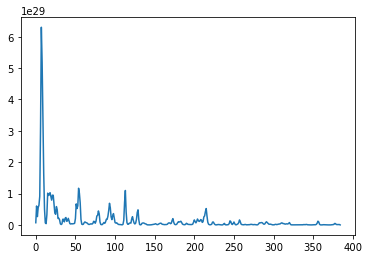

In [ ]:
plt.plot(freq_part_cut_aug_mul)

## Scipt version

In [ ]:
import sys
#!python -m pip install simpleaudio
#!python -m pip install librosa
import simpleaudio as sa
from scipy.io import wavfile
import scipy.io
from matplotlib import pyplot as plt
import numpy as np
from math import exp
import math
from IPython.display import Audio
from scipy.io.wavfile import read,write
import wave
import scipy as sp
import librosa

In [ ]:
#helper function
# function that split the dataset into windows. 
def split_data(data,overlap,winsize):
    number_of_intervals = int((len(data)-winsize)/(winsize*overlap))+1
    all_intervals = []
    for i in range(number_of_intervals):
        start = int(winsize*overlap)*i
        all_intervals.append(data[start:start+winsize])
    return all_intervals
# we define the fast fourrier transform function where the results's sign are consistant with numpy.fft
def fft_2(lsy):
    #length of data should be 2m and m = 2^p for some interger p
    #note the x value are assumed or shifted to -pi to pi with 2m uniformely spaced nodes
    n=len(lsy)
    if ((n-1)&(n)!=0) :#use bitwise operation to check if n is power of 2
        return "data length not power of 2 or data not give"
    m=int(n/2)
    p=1
    while 2**p != m:
        p+=1
    My=np.reshape(lsy,(2,-1))  
    omg_0=np.array([[1,1],[1,-1]])
    omg=np.exp(-1j*np.pi) 
    My=np.matmul(omg_0,My) #we transform function value into the first layer of coefitient value by combinning two function values  
    #this code is motivated by the fact that if we devide  the lsy one time and stack into two matrixes of twice
    #the coresponding two entries of  sub matrix will be in two different odd/even group for the last devide, but in the same group in the second to last devide,
    #this is due to the fact that the entries's absolute index will corespond to reminder of k devide by n/i where i is the number of splits took place in the algorithm
    #we keep going up a level and eventually we will get the coefitient q
    for i in range(p):
        q=i+1
        mid=int(len(My[0])/2)
        My_even=My[:,:mid]
        My_odd=My[:,mid:]
        omg_q=omg**(1/(2**q))
        lsomg=np.array([omg_q**j for j in range(2**q)])[:,None]
        My=np.vstack([My_even+lsomg*My_odd,My_even-lsomg*My_odd])
    return   My.ravel()/n#return normalized results where sign is consistant with numpy package


In [ ]:
#all parameter input:
filename = 'gingervoicelow.wav'
# filename='do 32bit.wav'

overlap=0.5
winsize = 2**13
high_pass_target=80
low_pass_target=600
zero_padding_multiple=2**2

In [ ]:
#play file
wave_obj = sa.WaveObject.from_wave_file(filename)
play_obj = wave_obj.play()
play_obj.wait_done()
Audio(filename)

In [ ]:
####importing file
bitrate,data= wavfile.read(filename)
length = data.shape[0] / bitrate
#choose one channel if multichannel
if type(data[0])==type(np.array([])):
    data=data[:,0]
    
length = data.shape[0] / bitrate
N = len(data)

#split data
data_split= split_data(data,overlap,winsize)

hamming_window = lambda n: 0.54-0.46*np.cos(2*np.pi*n/(winsize-1))
data_split_window = []
for i in range(len(data_split)):
    d = data_split[i]
    modified_d = [d[i]*hamming_window(i) for i in range(winsize)]
    data_split_window.append(np.array(modified_d))
    
#padding the data with zeros
data_split_window_pad=data_split_window
paded_zeros=np.zeros(int(winsize*(zero_padding_multiple-1)))
for i in range(len(data_split_window)):
    data_split_window_pad[i]=np.append(data_split_window_pad[i],paded_zeros)

#finding possible frequecy for paded results    
winsize_pad=winsize*zero_padding_multiple
possible_freq_pad=bitrate/(winsize_pad)*np.array(range(0,winsize_pad))
for i in range( len(possible_freq_pad)):
    if possible_freq_pad[i]>= high_pass_target:
        high_pass_pad_index=i+1
        high_pass_pad_freq=possible_freq_pad[i+1]
        break
for i in range( high_pass_pad_index, len(possible_freq_pad)):
    if possible_freq_pad[i]>= low_pass_target:#260:
        low_pass_pad_index=i-1
        low_pass_pad_freq=possible_freq_pad[i-1]
        break

possible_freq_pad_cut=possible_freq_pad[high_pass_pad_index:low_pass_pad_index+1]

#find the list of fundemental frequency through HPS and apply stablization
partials=min(low_pass_target//high_pass_target,7)

fund_freq_list=[]
for k in range(0,len(data_split_window_pad)):
    freq_pad=fft_2(data_split_window_pad[k])#replace with our own fft function
    freq_pad_cut=freq_pad[high_pass_pad_index:low_pass_pad_index+1]
    list_freq_cut=[freq_pad_cut]
    for n in range(2,partials+1):
        freq_part= sp.signal.resample(freq_pad, len(freq_pad) // n)
        freq_part_cut=freq_part[high_pass_pad_index:low_pass_pad_index+1]
        list_freq_cut.append(freq_part_cut)
    
    #stabalize and multiply data
    freq_part_cut_aug_mul=1
    for f in list_freq_cut:
        freq_part_cut_aug=np.array([])
        x=np.abs(np.real(f[1]))+np.abs(np.imag(f[1]))+2*(np.abs(np.real(f[0])+np.imag(f[0])))        
        freq_part_cut_aug=np.append(freq_part_cut_aug,x)
        n=len(f)
        for i in range(1,n-1):
            x=0
            for j in range(0,3):
                if j==0 or j==2:
                    weight=1
                else:
                    weight=2
                y=f[i+j-1]
                x+=(np.abs(np.real(y))+np.abs(np.imag(y)))*weight
            freq_part_cut_aug=np.append(freq_part_cut_aug,x)
        x=np.abs(np.real(f[-2]))+np.abs(np.imag(f[-2]))+2*(np.abs(np.real(f[-1])+np.imag(f[-1])))
        freq_part_cut_aug=np.append(freq_part_cut_aug,x)
        freq_part_cut_aug_mul=freq_part_cut_aug_mul*freq_part_cut_aug
    fund_freq_list.append(possible_freq_pad_cut[np.argmax(freq_part_cut_aug_mul)])

    
#get results:

In [ ]:
fund_freq_list

[141.3116455078125,
 141.3116455078125,
 139.9658203125,
 139.9658203125,
 139.9658203125,
 139.9658203125,
 139.9658203125,
 139.9658203125,
 138.6199951171875,
 139.9658203125,
 138.6199951171875,
 138.6199951171875,
 139.9658203125,
 139.9658203125,
 139.9658203125,
 139.9658203125,
 139.9658203125,
 139.9658203125,
 139.9658203125,
 141.3116455078125,
 142.657470703125,
 142.657470703125,
 142.657470703125,
 141.3116455078125,
 141.3116455078125,
 141.3116455078125,
 142.657470703125,
 142.657470703125,
 142.657470703125,
 141.3116455078125,
 141.3116455078125,
 141.3116455078125,
 139.9658203125,
 139.9658203125,
 94.207763671875,
 91.51611328125]

## Function  version

In [1]:
import sys
#!python -m pip install simpleaudio
#!python -m pip install librosa
#import simpleaudio as sa
from scipy.io import wavfile
import scipy.io
from matplotlib import pyplot as plt
import numpy as np
from math import exp
import math
from IPython.display import Audio
from scipy.io.wavfile import read,write
import wave
import scipy as sp
import librosa

In [2]:
#helper function
# function that split the dataset into windows. 
def split_data(data,overlap,winsize):
    number_of_intervals = int((len(data)-winsize)/(winsize*overlap))+1
    all_intervals = []
    for i in range(number_of_intervals):
        start = int(winsize*overlap)*i
        all_intervals.append(data[start:start+winsize])
    return all_intervals
# we define the fast fourrier transform function where the results's sign are consistant with numpy.fft
def fft_2(lsy):
    #length of data should be 2m and m = 2^p for some interger p
    #note the x value are assumed or shifted to -pi to pi with 2m uniformely spaced nodes
    n=len(lsy)
    if ((n-1)&(n)!=0) :#use bitwise operation to check if n is power of 2
        return "data length not power of 2 or data not give"
    m=int(n/2)
    p=1
    while 2**p != m:
        p+=1
    My=np.reshape(lsy,(2,-1))  
    omg_0=np.array([[1,1],[1,-1]])
    omg=np.exp(-1j*np.pi) 
    My=np.matmul(omg_0,My) #we transform function value into the first layer of coefitient value by combinning two function values  
    #this code is motivated by the fact that if we devide  the lsy one time and stack into two matrixes of twice
    #the coresponding two entries of  sub matrix will be in two different odd/even group for the last devide, but in the same group in the second to last devide,
    #this is due to the fact that the entries's absolute index will corespond to reminder of k devide by n/i where i is the number of splits took place in the algorithm
    #we keep going up a level and eventually we will get the coefitient q
    for i in range(p):
        q=i+1
        mid=int(len(My[0])/2)
        My_even=My[:,:mid]
        My_odd=My[:,mid:]
        omg_q=omg**(1/(2**q))
        lsomg=np.array([omg_q**j for j in range(2**q)])[:,None]
        My=np.vstack([My_even+lsomg*My_odd,My_even-lsomg*My_odd])
    return   My.ravel()/n#return normalized results where sign is consistant with numpy package


In [ ]:
#old code
def fund_freq_old(file, high_pass_target, low_pass_target,
              overlap=0.5,
              winsize=2**13,
              zero_padding_multiple=2**2,
                  partials=False):

    bitrate,data= file
    length = data.shape[0] / bitrate
    #choose one channel if multichannel
    if type(data[0])==type(np.array([])):
        data=data[:,0]

    length = data.shape[0] / bitrate
    N = len(data)
    #split data
    data_split= split_data(data,overlap,winsize)

    hamming_window = lambda n: 0.54-0.46*np.cos(2*np.pi*n/(winsize-1))
    data_split_window = []
    for i in range(len(data_split)):
        d = data_split[i]
        modified_d = [d[i]*hamming_window(i) for i in range(winsize)]
        data_split_window.append(np.array(modified_d))

    #padding the data with zeros
    data_split_window_pad=data_split_window
    paded_zeros=np.zeros(int(winsize*(zero_padding_multiple-1)))
    for i in range(len(data_split_window)):
        data_split_window_pad[i]=np.append(data_split_window_pad[i],paded_zeros)

    #finding possible frequecy for paded results    
    winsize_pad=winsize*zero_padding_multiple
    possible_freq_pad=bitrate/(winsize_pad)*np.array(range(0,winsize_pad))
    for i in range( len(possible_freq_pad)):
        if possible_freq_pad[i]>= high_pass_target:
            high_pass_pad_index=i+1
            high_pass_pad_freq=possible_freq_pad[i+1]
            break
    for i in range( high_pass_pad_index, len(possible_freq_pad)):
        if possible_freq_pad[i]>= low_pass_target:#260:
            low_pass_pad_index=i-1
            low_pass_pad_freq=possible_freq_pad[i-1]
            break

    possible_freq_pad_cut=possible_freq_pad[high_pass_pad_index:low_pass_pad_index+1]
    
    #deciding how many partials to performe
    if not partials:
        partials=min(low_pass_target//high_pass_target,7)
    else:
        partials= int(partials)
    
    #find the list of fundemental frequency through HPS and apply stablization
    fund_freq_list=[]
    for k in range(0,len(data_split_window_pad)):
        freq_pad=fft_2(data_split_window_pad[k])#replace with our own fft function
        freq_pad_cut=freq_pad[high_pass_pad_index:low_pass_pad_index+1]
        list_freq_cut=[freq_pad_cut]
        for n in range(2,partials+1):
            freq_part= sp.signal.resample(freq_pad, len(freq_pad) // n)
            freq_part_cut=freq_part[high_pass_pad_index:low_pass_pad_index+1]
            list_freq_cut.append(freq_part_cut)

        #stabalize and multiply data
        freq_part_cut_aug_mul=1
        for f in list_freq_cut:
            freq_part_cut_aug=np.array([])
            x=2*(np.abs(np.real(f[1]))+np.abs(np.imag(f[1])))+4*(np.abs(np.real(f[0]))+np.abs(np.imag(f[0])))       
            freq_part_cut_aug=np.append(freq_part_cut_aug,x)
            n=len(f)
            for i in range(1,n-1):
                x=0
                for j in range(0,3):
                    if j==0 or j==2:
                        weight=1
                    else:
                        weight=4
                    y=f[i+j-1]
                    x+=(np.abs(np.real(y))+np.abs(np.imag(y)))*weight
                freq_part_cut_aug=np.append(freq_part_cut_aug,x)
            x=2*np.abs(np.real(f[-2]))+np.abs(np.imag(f[-2]))+4*(np.abs(np.real(f[-1]))+np.abs(np.imag(f[-1])))     
            freq_part_cut_aug=np.append(freq_part_cut_aug,x)
            freq_part_cut_aug_mul=freq_part_cut_aug_mul*freq_part_cut_aug
        fund_freq_list.append(possible_freq_pad_cut[np.argmax(freq_part_cut_aug_mul)])
    return fund_freq_list

In [6]:
def fund_freq(file, high_pass_target, low_pass_target,
              overlap=0.5,
              winsize=2**13,
              zero_padding_multiple=2**2,
             partials=False):

    bitrate,data= file
    length = data.shape[0] / bitrate
    #choose one channel if multichannel
    if type(data[0])==type(np.array([])):
        data=data[:,0]

    length = data.shape[0] / bitrate
    N = len(data)
    #split data
    data_split= split_data(data,overlap,winsize)

    hamming_window = lambda n: 0.54-0.46*np.cos(2*np.pi*n/(winsize-1))
    data_split_window = []
    for i in range(len(data_split)):
        d = data_split[i]
        modified_d = [d[i]*hamming_window(i) for i in range(winsize)]
        data_split_window.append(np.array(modified_d))

    #padding the data with zeros
    data_split_window_pad=data_split_window
    paded_zeros=np.zeros(int(winsize*(zero_padding_multiple-1)))
    for i in range(len(data_split_window)):
        data_split_window_pad[i]=np.append(data_split_window_pad[i],paded_zeros)

    #finding possible frequecy for paded results    
    winsize_pad=winsize*zero_padding_multiple
    possible_freq_pad=bitrate/(winsize_pad)*np.array(range(0,winsize_pad))
    for i in range( len(possible_freq_pad)):
        if possible_freq_pad[i]>= high_pass_target:
            high_pass_pad_index=i+1
            high_pass_pad_freq=possible_freq_pad[i+1]
            break
    for i in range( high_pass_pad_index, len(possible_freq_pad)):
        if possible_freq_pad[i]>= low_pass_target:#260:
            low_pass_pad_index=i-1
            low_pass_pad_freq=possible_freq_pad[i-1]
            break

    possible_freq_pad_cut=possible_freq_pad[high_pass_pad_index:low_pass_pad_index+1]

    #deciding how many partials to performe
    if not partials:
        partials=min(low_pass_target//high_pass_target,7)
    else:
        partials= int(partials)
    
    #find the list of fundemental frequency through HPS and apply stablization
    fund_freq_list=[]
    peek_freq_index_list=[]
    freq_pad_cut_list=[]#list of cutted frequency of all windows
    for k in range(0,len(data_split_window_pad)):
        freq_pad=fft_2(data_split_window_pad[k])#replace with our own fft function
        freq_pad_cut=freq_pad[high_pass_pad_index:low_pass_pad_index+1]
        freq_pad_cut_list.append(freq_pad_cut)
        list_freq_cut=[freq_pad_cut]#list of all reduced frequency for each window
        for n in range(2,partials+1):
            freq_part= sp.signal.resample(freq_pad, len(freq_pad) // n)
            freq_part_cut=freq_part[high_pass_pad_index:low_pass_pad_index+1]
            list_freq_cut.append(freq_part_cut)
            
    

        #stabalize and multiply data
        freq_part_cut_aug_mul=1

        for f in list_freq_cut:    
            freq_part_cut_aug=np.array([])
            x=2*(np.abs(np.real(f[1]))+np.abs(np.imag(f[1])))+4*(np.abs(np.real(f[0]))+np.abs(np.imag(f[0])))       
            freq_part_cut_aug=np.append(freq_part_cut_aug,x)
            n=len(f)
            for i in range(1,n-1):
                x=0
                for j in range(0,3):
                    if j==0 or j==2:
                        weight=1
                    else:
                        weight=4
                    y=f[i+j-1]
                    x+=(np.abs(np.real(y))+np.abs(np.imag(y)))*weight
                freq_part_cut_aug=np.append(freq_part_cut_aug,x)
            x=2*np.abs(np.real(f[-2]))+np.abs(np.imag(f[-2]))+4*(np.abs(np.real(f[-1]))+np.abs(np.imag(f[-1])))     
            freq_part_cut_aug=np.append(freq_part_cut_aug,x)
            freq_part_cut_aug_mul=freq_part_cut_aug_mul*freq_part_cut_aug
        peek_freq_index_list.append(np.argmax(freq_part_cut_aug_mul))
    
    #find true max fruequency
    hopsize=int(overlap*winsize_pad)#notsure winsize or winsize_pad
    prev_phase=0
    for k in range(0,len(peek_freq_index_list)):
        max_index=peek_freq_index_list[k]
        curr_phase=np.angle(freq_pad_cut_list[k][max_index])
        if k!=0:
             prev_phase=np.angle(freq_pad_cut_list[k-1][max_index])
        bin_freq=possible_freq_pad_cut[max_index]
        phase_change=(curr_phase-prev_phase)/(2*np.pi)*bitrate-hopsize*bin_freq
        #re-map
        phase_change_mod=((phase_change+bitrate/2)%(bitrate))-bitrate/2
        true_fund_freq=bin_freq+(phase_change_mod/hopsize)
        
        fund_freq_list.append(true_fund_freq)
    return fund_freq_list 

In [18]:
#filename = 'gingervoicehigh.wav'
#filename = 'thank-god-its-friday.wav'
filename='Output 3-2.wav'
file=wavfile.read(filename)
result1=fund_freq(file, 257,490,zero_padding_multiple=4,winsize=2**13)
time = len(file[1])/(file[0])
#,zero_padding_multiple=1)
#result2=fund_freq_old(file, 257,490,zero_padding_multiple=4,winsize=2**13)#,zero_padding_multiple=1)
#result3=fund_freq(file, 100,600,zero_padding_multiple=8)
#result4=fund_freq_old(file, 100,600,zero_padding_multiple=8)

<ipython-input-18-eb6107402014>:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file=wavfile.read(filename)


In [14]:
file2 = wavfile.read('Output 1-2.wav')
result2 = fund_freq(file2, 120,490,zero_padding_multiple=4,winsize=2**13)

<ipython-input-14-009740b16757>:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file2 = wavfile.read('Output 1-2.wav')
<ipython-input-14-009740b16757>:1: WavFileWarning: Incomplete chunk ID: b'\x00', ignoring it.
  file2 = wavfile.read('Output 1-2.wav')


In [8]:
time2 = len(file2[1])/(file2[0])

NameError: name 'file2' is not defined

Text(0, 0.5, 'Frequency (Hz)')

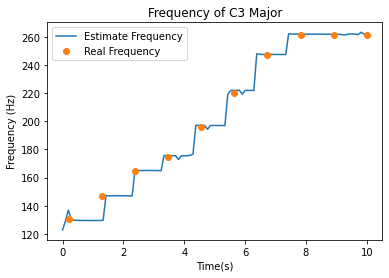

In [31]:
plt.plot(np.linspace(0,time2,len(result2)),result2,label='Estimate Frequency')
plt.plot(np.linspace(0.2,time2,10),piano_key,'o',label = 'Real Frequency')
plt.title('Frequency of C3 Major')
plt.legend()
plt.xlabel('Time(s)')
plt.ylabel('Frequency (Hz)')

In [12]:
key_32 = [261.63,261.63,392,392,440,440,392,392,349.23,349.23,329.63,329.63,293.66,293.66,261.63,261.63]

Text(0, 0.5, 'Frequency (Hz)')

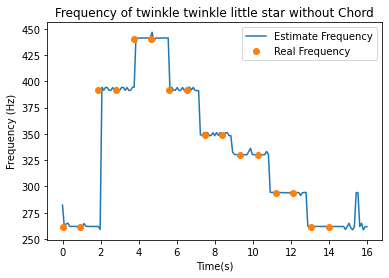

In [25]:
plt.plot(np.linspace(0,16,len(result1)),result1,label='Estimate Frequency')
plt.plot(np.linspace(0,14,16),key_32,'o',label = 'Real Frequency')
plt.title('Frequency of twinkle twinkle little star without Chord')
plt.legend()
plt.xlabel('Time(s)')
plt.ylabel('Frequency (Hz)')
#plt.plot(result2[:])
#plt.yscale("log")

In [ ]:
filename3 = 'Output 3-3.wav'
file=wavfile.read(filename3)
freq_3 = fund_freq(file, 257,490,600)
plt.plot(np.linspace(0,16,len(freq_3)),freq_3,label='Estimate Frequency')
plt.plot(np.linspace(0,14,16),key_32,'o',label = 'Real Frequency')
plt.title('Frequency of twinkle twinkle little star without Chord')
plt.legend()
plt.xlabel('Time(s)')
plt.ylabel('Frequency (Hz)')

### Data test

In [ ]:
filename = 'gingervoicelow.wav'
file=wavfile.read(filename)
fund_freq(file, 80,600)

[141.3116455078125,
 141.3116455078125,
 139.9658203125,
 139.9658203125,
 139.9658203125,
 139.9658203125,
 139.9658203125,
 139.9658203125,
 138.6199951171875,
 139.9658203125,
 138.6199951171875,
 138.6199951171875,
 139.9658203125,
 139.9658203125,
 139.9658203125,
 139.9658203125,
 138.6199951171875,
 139.9658203125,
 139.9658203125,
 141.3116455078125,
 142.657470703125,
 142.657470703125,
 142.657470703125,
 141.3116455078125,
 141.3116455078125,
 141.3116455078125,
 142.657470703125,
 144.0032958984375,
 142.657470703125,
 141.3116455078125,
 141.3116455078125,
 141.3116455078125,
 139.9658203125,
 141.3116455078125,
 94.207763671875,
 91.51611328125]

In [ ]:
filename = 'gingervoicehigh.wav'
file=wavfile.read(filename)
fund_freq(file, 80,600)

[253.01513671875,
 251.6693115234375,
 246.2860107421875,
 244.940185546875,
 243.5943603515625,
 244.940185546875,
 243.5943603515625,
 242.24853515625,
 244.940185546875,
 246.2860107421875,
 246.2860107421875,
 244.940185546875,
 244.940185546875,
 244.940185546875,
 244.940185546875,
 243.5943603515625,
 243.5943603515625,
 242.24853515625,
 488.5345458984375,
 242.24853515625,
 242.24853515625,
 243.5943603515625,
 242.24853515625,
 243.5943603515625,
 239.556884765625,
 125.1617431640625]

In [ ]:
filename = 'gingervoicehigh.wav'
file=wavfile.read(filename)
fund_freq(file, 100,300)

[253.01513671875,
 248.9776611328125,
 246.2860107421875,
 244.940185546875,
 244.940185546875,
 244.940185546875,
 243.5943603515625,
 242.24853515625,
 244.940185546875,
 247.6318359375,
 246.2860107421875,
 243.5943603515625,
 244.940185546875,
 244.940185546875,
 244.940185546875,
 242.24853515625,
 244.940185546875,
 242.24853515625,
 243.5943603515625,
 240.9027099609375,
 240.9027099609375,
 242.24853515625,
 242.24853515625,
 247.6318359375,
 239.556884765625,
 244.940185546875]

In [ ]:
filename = 'gingervoicehigh.wav'
file=wavfile.read(filename)
fund_freq(file, 40,1200)

[253.01513671875,
 251.6693115234375,
 246.2860107421875,
 244.940185546875,
 243.5943603515625,
 244.940185546875,
 243.5943603515625,
 242.24853515625,
 244.940185546875,
 246.2860107421875,
 246.2860107421875,
 244.940185546875,
 244.940185546875,
 244.940185546875,
 244.940185546875,
 243.5943603515625,
 243.5943603515625,
 242.24853515625,
 488.5345458984375,
 242.24853515625,
 242.24853515625,
 243.5943603515625,
 242.24853515625,
 243.5943603515625,
 239.556884765625,
 125.1617431640625]

In [ ]:
filename = 'do 32bit.wav'
file=wavfile.read(filename)
fund_freq(file, 40,500)

<ipython-input-31-1888ee995b87>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file=wavfile.read(filename)
<ipython-input-31-1888ee995b87>:2: WavFileWarning: Incomplete chunk ID: b'\x00', ignoring it.
  file=wavfile.read(filename)


[65.9454345703125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 130.5450439453125,
 131.890869140625,
 263.78173828125,
 262.4359130859375,
 262.4359130859375,
 262.4359130859375,
 262.4359130859375,
 262.4359130859375,
 262.4359130859375,
 262.4359130859375,
 262.4359130859375,
 263.78173828125,
 262.4359130859375,
 261.090087890625,
 262.4359130859375,
 262.4359130859375,
 262.4359130859375,
 262.4359130859375,
 262.4359130859375,
 262.4359130859375,
 261.090087890625,
 262.4359130859375,
 262.435

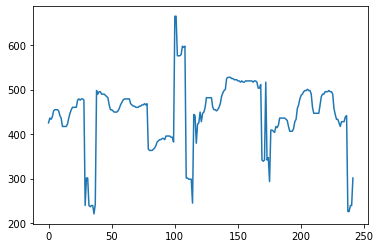

In [ ]:
filename = 'thank-god-its-friday.wav'
file=wavfile.read(filename)
results=fund_freq(file, 200,700,overlap=0.1,
              winsize=2**12)
plt.plot(results)
#results